# Khai phá dữ liệu (Data Exploring Analysis)
Mục tiêu EDA
Hiểu cấu trúc & chất lượng dữ liệu trước khi xây dựng mô hình.

Xác định phân bố nhãn, phát hiện mất cân bằng, trường dư thừa hoặc rò rỉ.

Kiểm chứng tính nhất quán giữa file CSV mô tả và thư mục ảnh thực tế.

In [6]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import kagglehub

Trước hết chúng sẽ đọc ba tệp CSV gồm: Meta.csv, Train.csv và Test.csv, đồng thời tiến hành khai phá từng tệp dữ liệu này.



In [7]:
data_path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign") + '/'
train_path = data_path + 'Train/'
test_path = data_path + 'Test/'
df_meta = pd.read_csv(data_path + 'Meta.csv')
df_train = pd.read_csv(data_path + 'Train.csv')
df_test = pd.read_csv(data_path + 'Test.csv')

In [41]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
           9:'No passing',
           10:'No passing veh over 3.5 tons',
           11:'Right-of-way at intersection',
           12:'Priority road',
           13:'Yield',
           14:'Stop',
           15:'No vehicles',
           16:'Veh > 3.5 tons prohibited',
           17:'No entry',
           18:'General caution',
           19:'Dangerous curve left',
           20:'Dangerous curve right',
           21:'Double curve',
           22:'Bumpy road',
           23:'Slippery road',
           24:'Road narrows on the right',
           25:'Road work',
           26:'Traffic signals',
           27:'Pedestrians',
           28:'Children crossing',
           29:'Bicycles crossing',
           30:'Beware of ice/snow',
           31:'Wild animals crossing',
           32:'End speed + passing limits',
           33:'Turn right ahead',
           34:'Turn left ahead',
           35:'Ahead only',
           36:'Go straight or right',
           37:'Go straight or left',
           38:'Keep right',
           39:'Keep left',
           40:'Roundabout mandatory',
           41:'End of no passing',
           42:'End no passing veh > 3.5 tons' }

## Khai phá tập mô tả (Meta Dataframe)

In [42]:
df_meta.head(20)


,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22
5,Meta/12.png,12,2,2,2.3
6,Meta/13.png,13,4,0,2.1
7,Meta/14.png,14,3,0,2.2
8,Meta/15.png,15,1,0,3.1
9,Meta/16.png,16,1,0,3.3


Bảng dữ liệu df_meta lưu trữ thông tin mô tả về các biển báo giao thông trong tập dữ liệu GTSRB.

Có năm trường trong tập mô tả: **Path, ClassId, ShapeId, ColorId, SignId**

In [9]:
print("Min. Class Label: {}".format(df_meta.ClassId.min()))
print("Max Class Label: {}".format(df_meta.ClassId.max()))
print("Total Class Labels: {}".format(len(df_meta.ClassId.unique())))

Min. Class Label: 0
Max Class Label: 42
Total Class Labels: 43


Tổng cộng có 43 lớp (từ 0 đến 42), được mô tả bằng 5 trường (Path, ClassId, ShapeId, ColorId, SignId).






### Biểu đồ trực quan các hình ảnh mẫu cho từng lớp biển báo.

In [10]:
num_classes = len(df_meta.ClassId.unique())
class_dict = {}
class_labels = list(range(num_classes))
# Speed Class 0-9
speed_class = ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['20', '30', '50', '60', '70', '80']]]\
            + ['End of Speed Limit 80 kmph']
speed_class+= ['Speed Limit ' + item for item in [speed + ' kmph' for speed in ['100', '120']]]
speed_class
# 10, 11 No Passing
no_pass = ['No Passing' + item for item in ['', ' vehicle over 3.5 ton']]
# 12-43
rest = ['Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',\
            'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road',
            'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
            'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 'End speed + passing limits', 'Turn right ahead',
            'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left',
            'Roundabout mandatory', 'End of no passing', 'End no passing vehicle > 3.5 tons']
class_values = speed_class + no_pass + rest
class_dict = {keys:values for keys,values in zip(class_labels, class_values)}

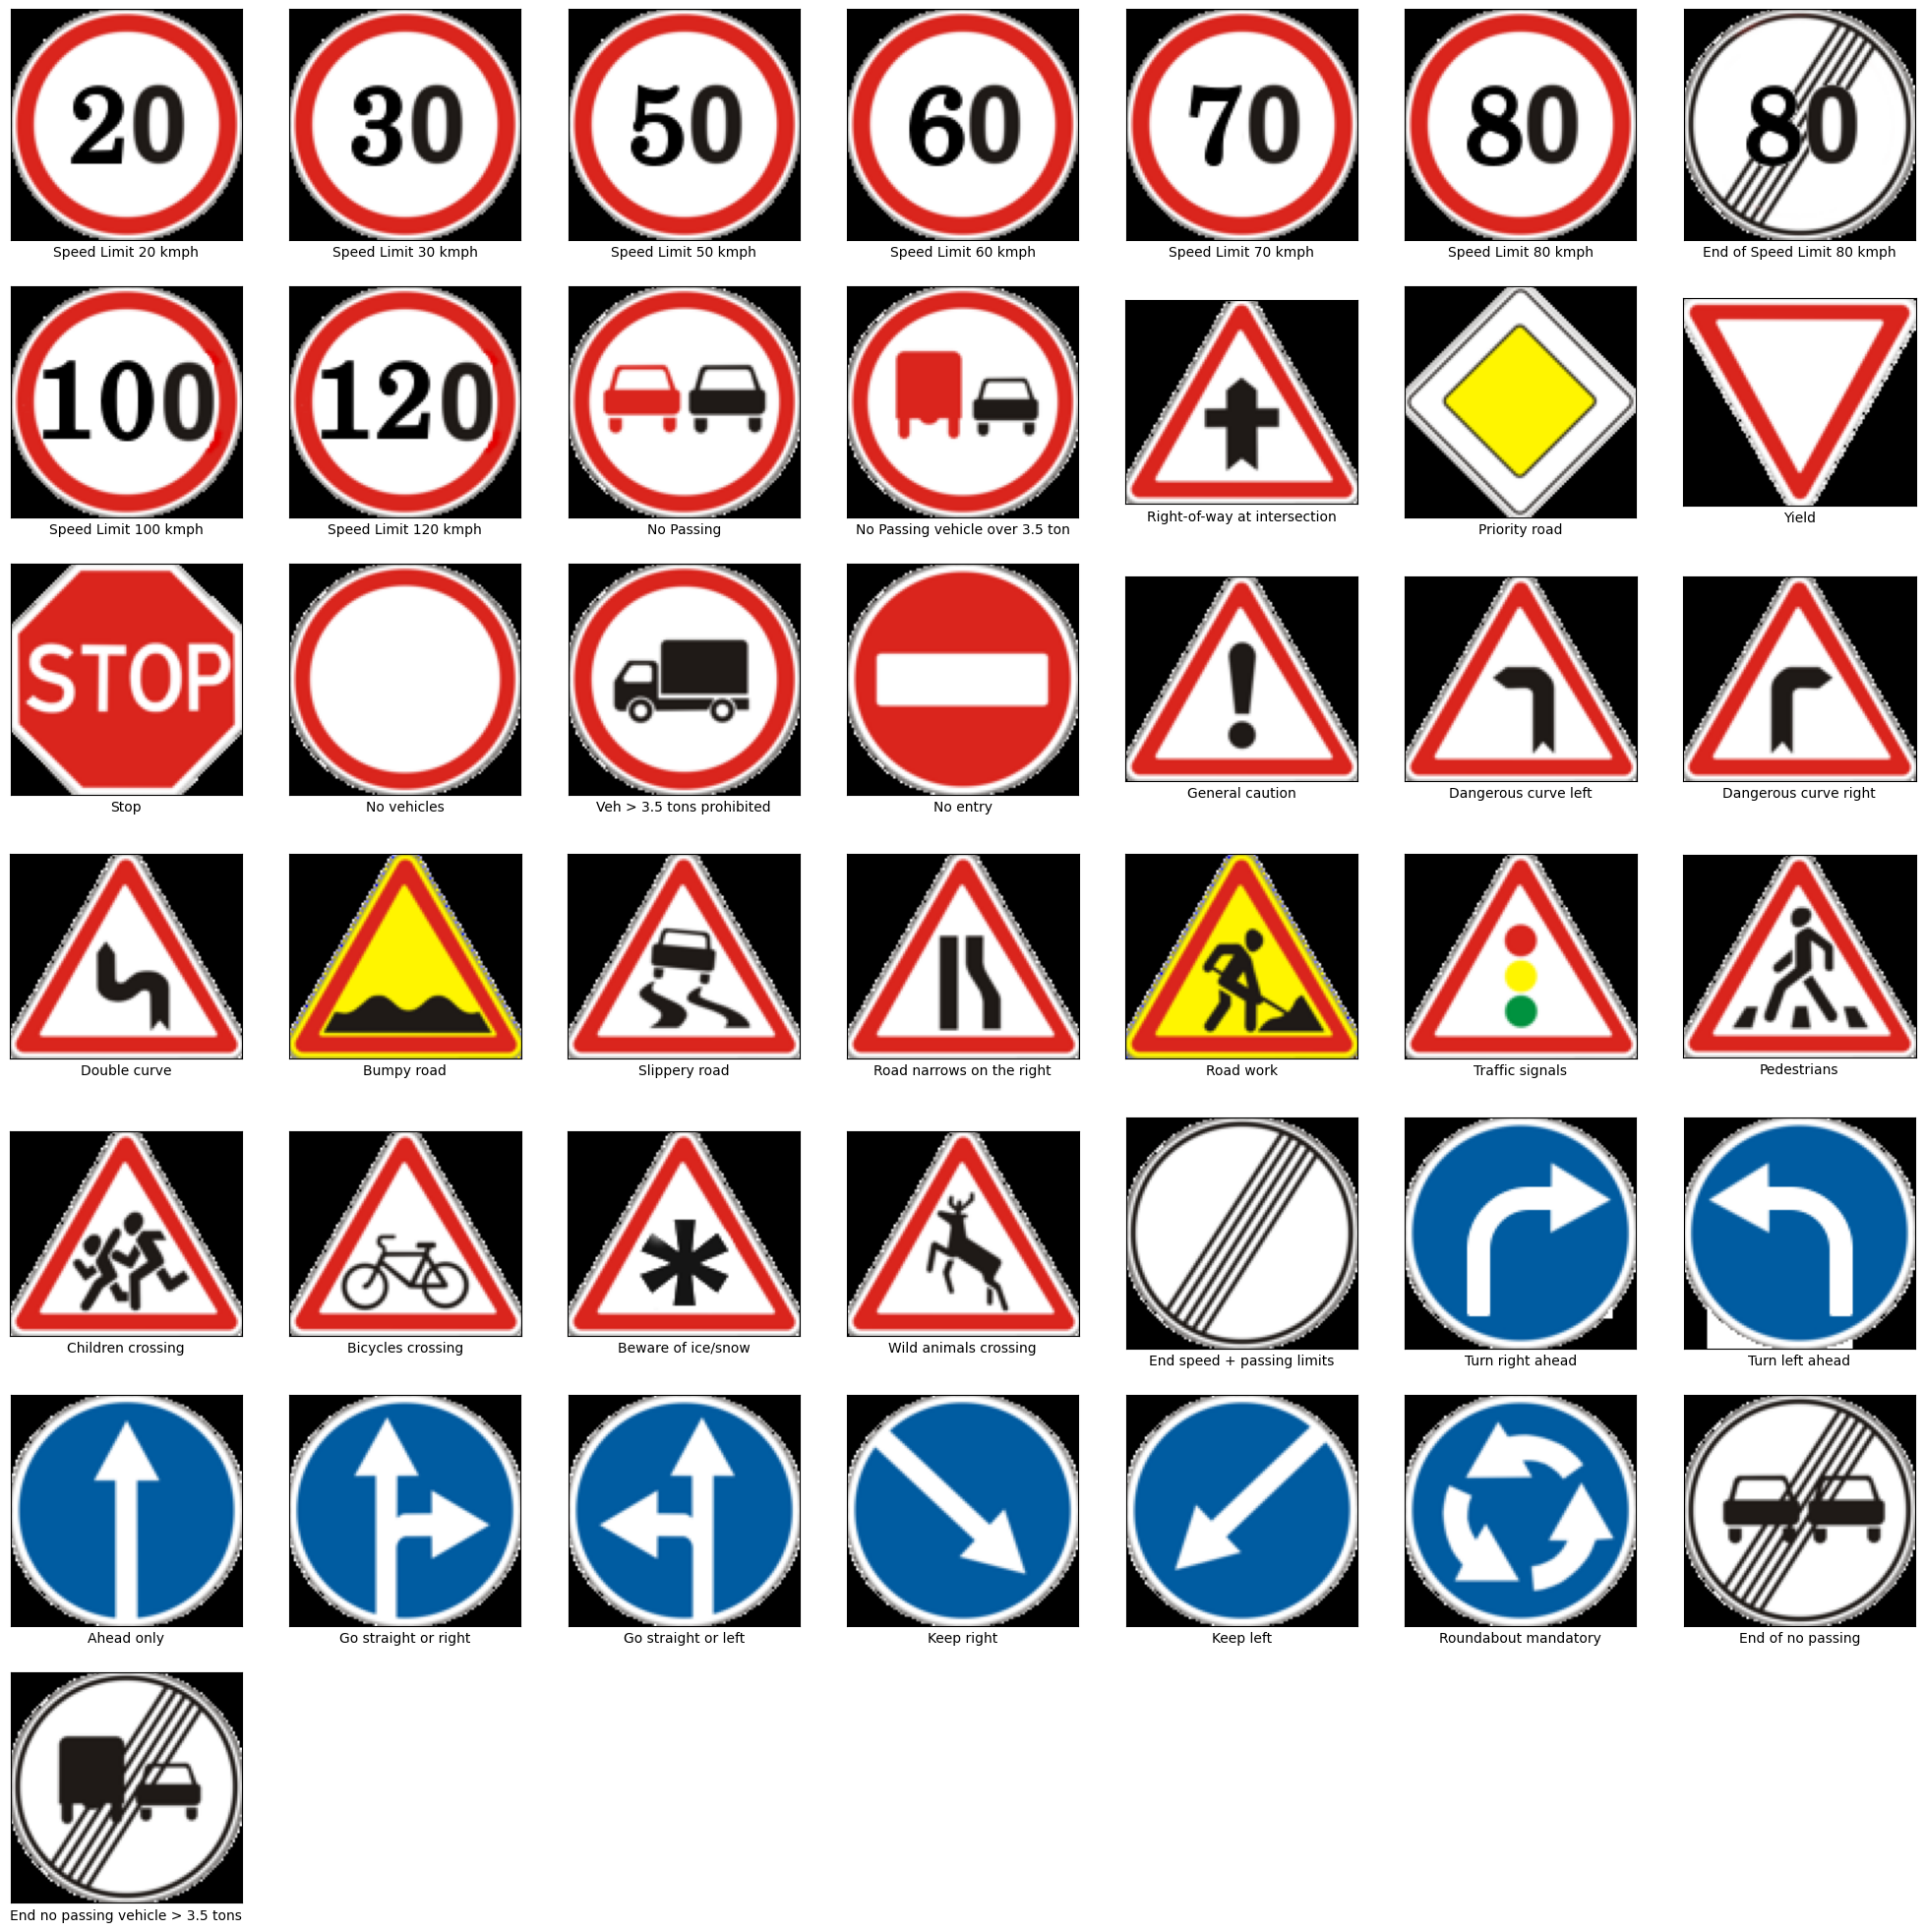

In [11]:
sortFunction = lambda x: int(os.path.basename(x)[:-4])
plt.figure(figsize = (25, 25))
for i, imagename in enumerate(sorted(glob.glob(data_path + 'Meta/' + '*.*'), key = sortFunction)):
    plt.subplot(7, 7, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_dict[i])
    image = cv2.imread(imagename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
shape_dict = {0: 'Triangle', 1: 'Circle', 2: 'Diamond', 3: 'Hexagon', 4: 'Inverse Triangle'}
df_meta.ShapeId.value_counts()

,count
ShapeId,
1,25
0,15
2,1
4,1
3,1


 Hình tròn nhiều nhất (25 biển), tam giác (15 biển), các dạng khác rất ít (chỉ 1 biển mỗi dạng).


In [13]:
def visualize_shape(shape = 0):
    """
    Plots random samples of a particular shape from shape_dict
    """
    filenames = df_meta[df_meta.ShapeId==shape].sample(10).Path
    plt.figure(figsize = (25, 25))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(11, 4, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

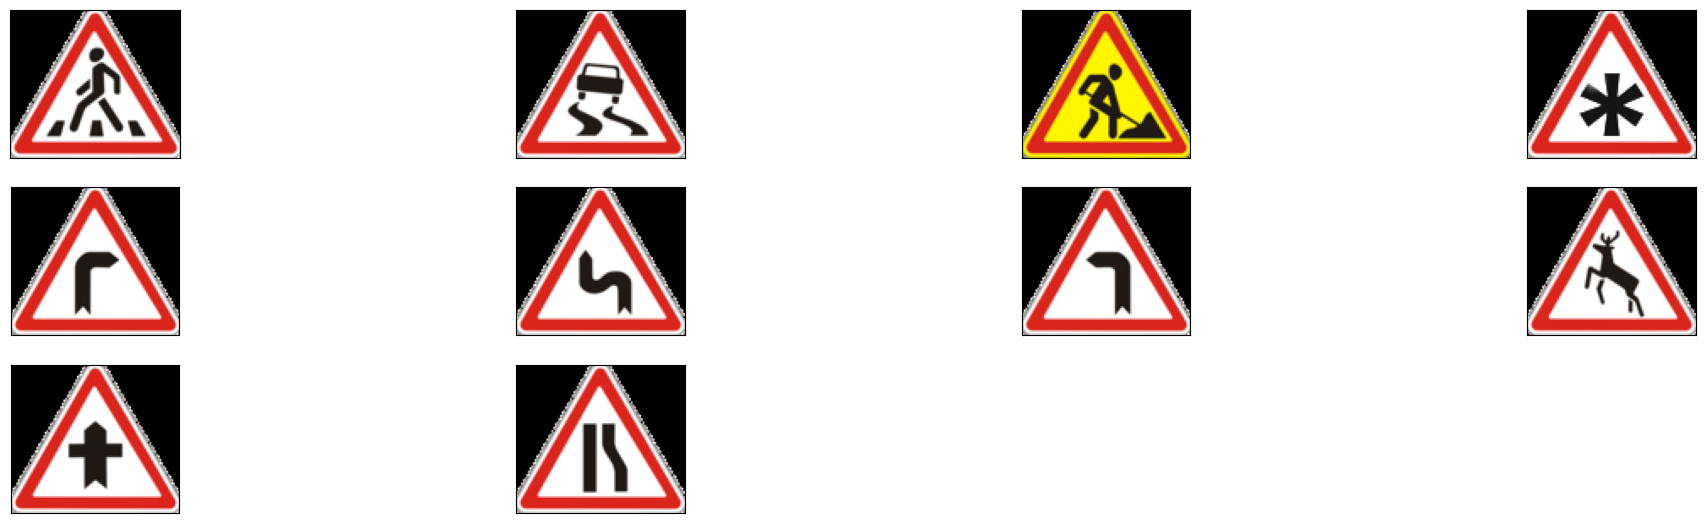

In [14]:
visualize_shape(0)


In [15]:

color_dict = {0:'Red', 1:'Blue', 2:'Yellow', 3:'White'}
df_meta.ColorId.value_counts()

,count
ColorId,
0,30
1,8
3,4
2,1



ColorId: Màu đỏ chiếm đa số (30 biển), xanh (8 biển), trắng (4 biển), vàng (1 biển).

In [16]:
def visualize_color(color = 0):
    """
    Plots random samples of a particular color from color_dict
    """
    filenames = df_meta[df_meta.ColorId==color].sample(5).Path
    plt.figure(figsize = (20, 20))
    for i, filename in enumerate(data_path + filenames):
        image = cv2.imread(filename)
        plt.subplot(1, 6, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

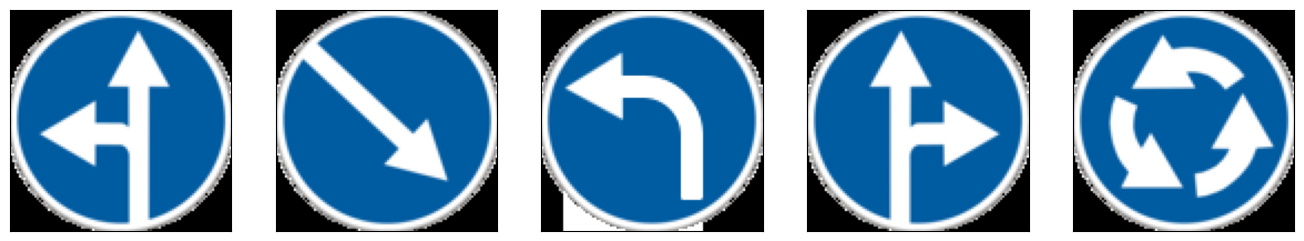

In [17]:
visualize_color(color = 1)


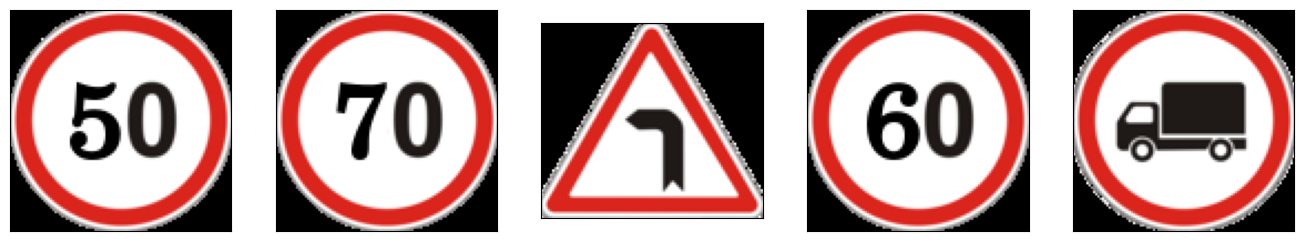

In [18]:
visualize_color(color = 0)


##Exploring Train Dataframe


In [22]:
df_train.shape


(39209, 8)

Kích thước: (39209, 8)



In [23]:
df_train.head()


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [24]:
df_train.describe()


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
count,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000,39209.000000
mean,50.835880,50.328930,5.999515,5.962381,45.197302,44.728379,15.788390
std,24.306933,23.115423,1.475493,1.385440,23.060157,21.971145,12.013238
min,25.000000,25.000000,0.000000,5.000000,20.000000,20.000000,0.000000
25%,35.000000,35.000000,5.000000,5.000000,29.000000,30.000000,5.000000
50%,43.000000,43.000000,6.000000,6.000000,38.000000,38.000000,12.000000
75%,58.000000,58.000000,6.000000,6.000000,53.000000,52.000000,25.000000
max,243.000000,225.000000,20.000000,20.000000,223.000000,205.000000,42.000000


In [44]:
class_counts = df_train['ClassId'].value_counts().sort_index()
class_counts_df = class_counts.reset_index()
class_counts_df.columns = ['ClassId', 'Count']
class_counts_df['ClassName'] = class_counts_df['ClassId'].map(classes)

In [45]:
class_counts_df


,ClassId,Count,ClassName
0,0,210,Speed limit (20km/h)
1,1,2220,Speed limit (30km/h)
2,2,2250,Speed limit (50km/h)
3,3,1410,Speed limit (60km/h)
4,4,1980,Speed limit (70km/h)
5,5,1860,Speed limit (80km/h)
6,6,420,End of speed limit (80km/h)
7,7,1440,Speed limit (100km/h)
8,8,1410,Speed limit (120km/h)
9,9,1470,No passing


Class nhiều nhất: Class 2 (2250 ảnh), ít nhất: Class 0, 19, 37 (210 ảnh).



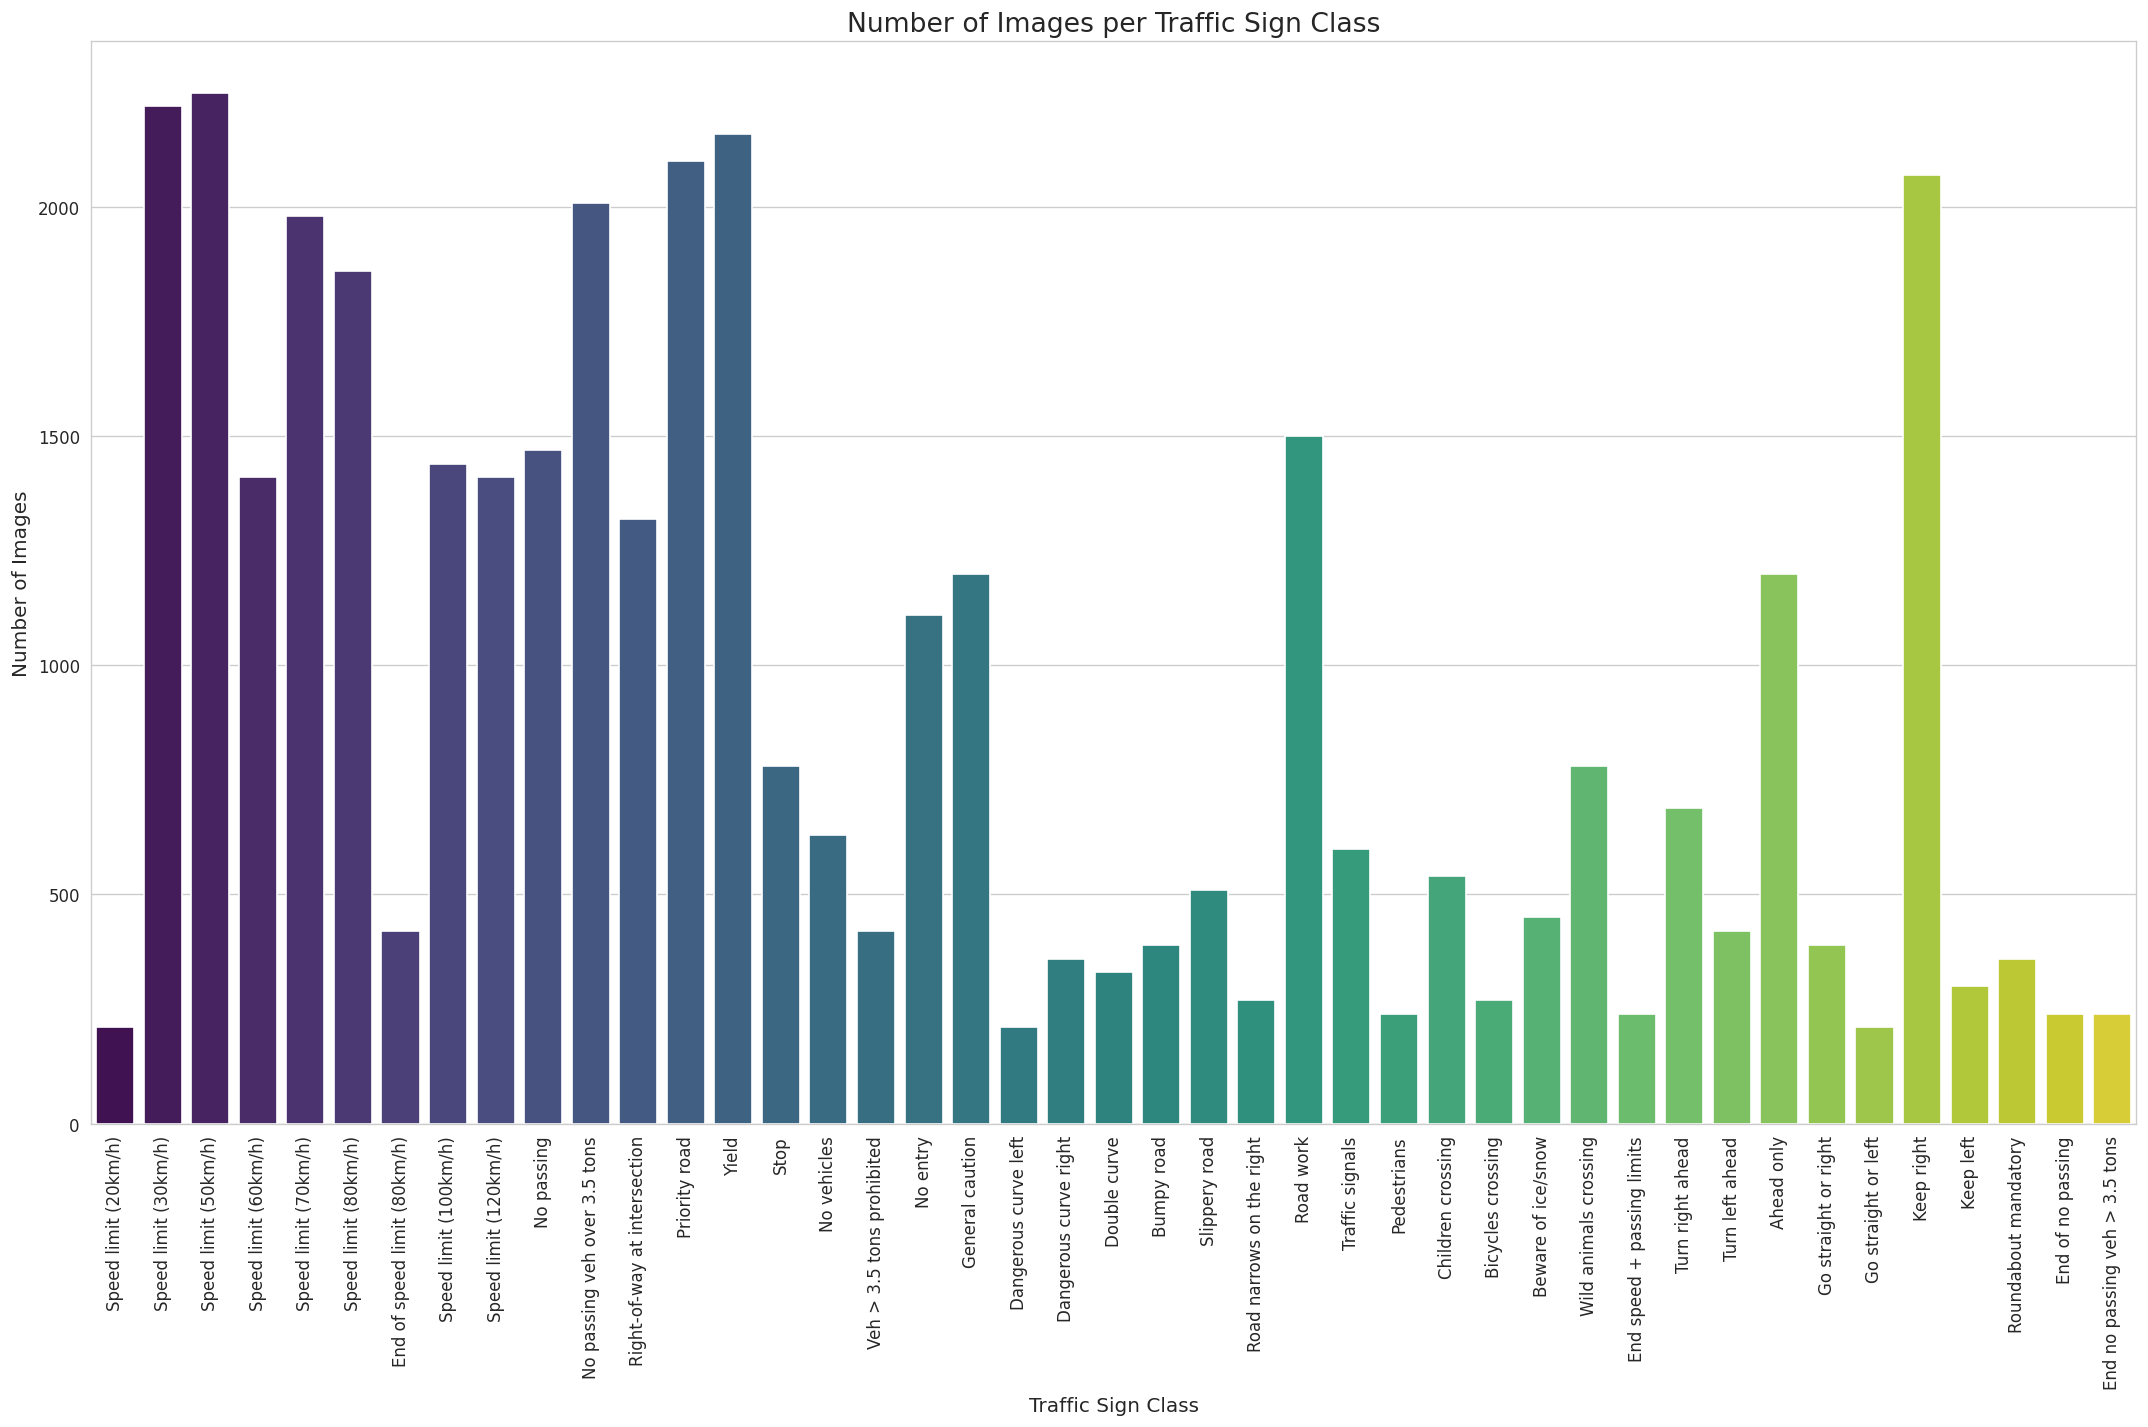

In [46]:
import seaborn as sns
sns.set_style('whitegrid')

plt.figure(figsize=(18, 12), dpi=120)
sns.barplot(data=class_counts_df, x='ClassName', y='Count', palette='viridis')
plt.title('Number of Images per Traffic Sign Class', fontsize=16)
plt.xlabel('Traffic Sign Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Các lớp 2 (2250 ảnh), 1 (2220 ảnh), 13 (2160 ảnh), 38 (2070 ảnh) vượt trội.

Mất cân bằng dữ liệu khá nghiêm trọng giữa các lớp.

In [25]:
df_train.ClassId.value_counts()


,count
ClassId,
2,2250
1,2220
13,2160
12,2100
38,2070
10,2010
4,1980
5,1860
25,1500


In [26]:
train_dict = {}
train_dict = {keys:values for keys,values in zip(df_train.ClassId.value_counts().index, df_train.ClassId.value_counts().tolist())}

Text(0.5, 1.0, 'Class Distribution for Training data')

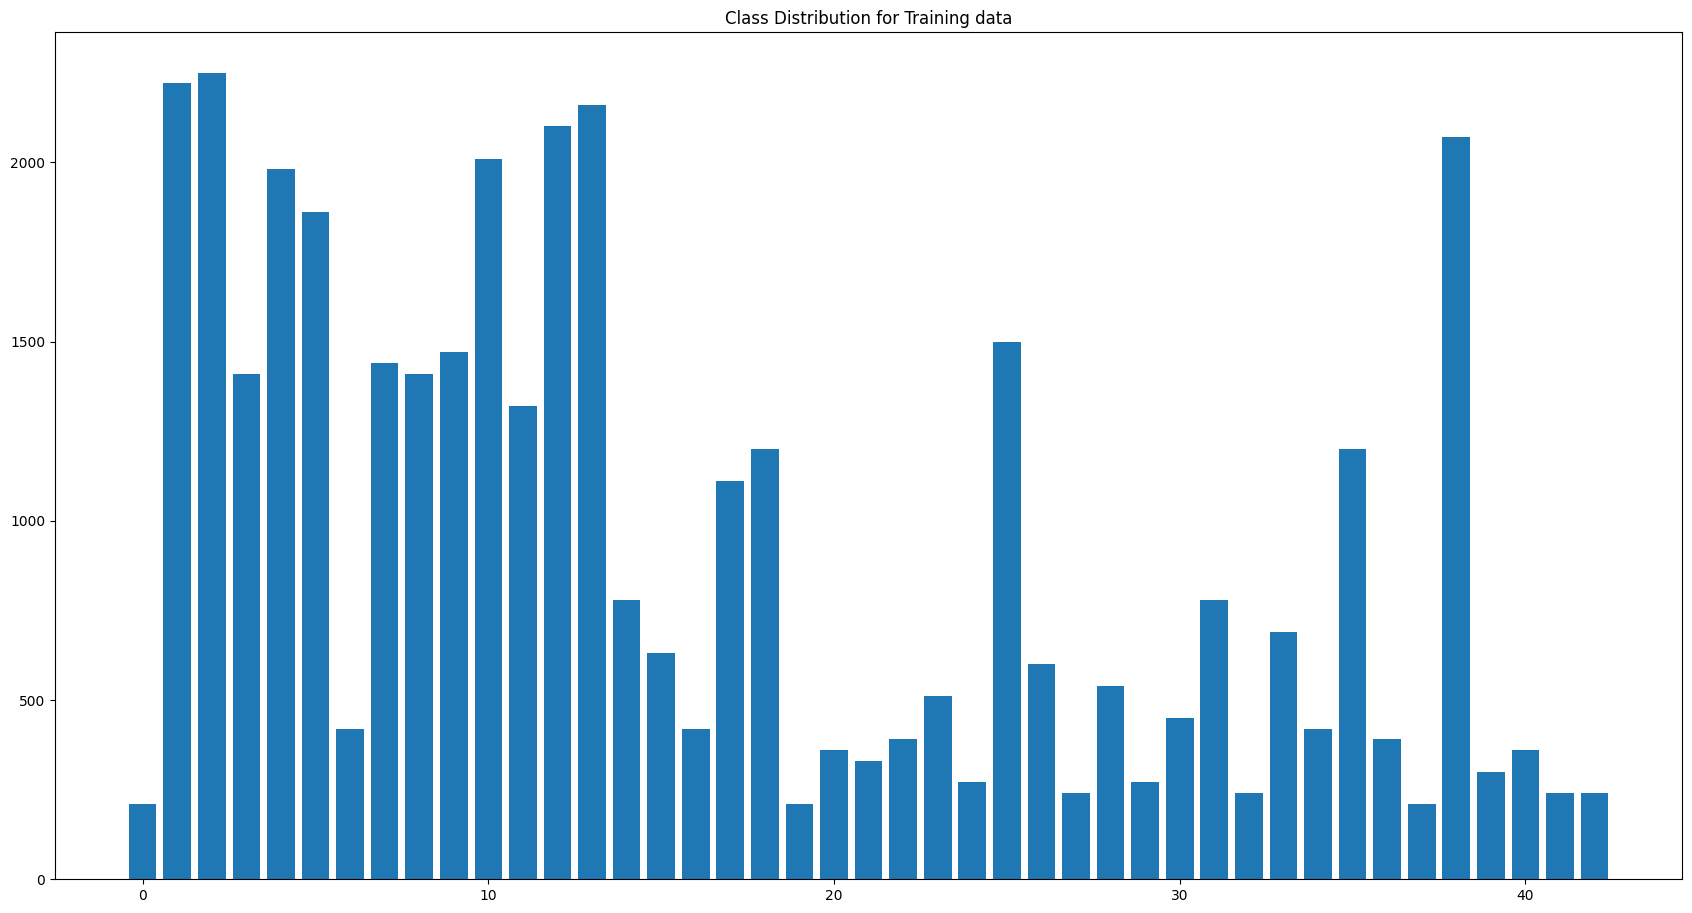

In [27]:

plt.figure(figsize = (21 ,11))
plt.bar(train_dict.keys(), train_dict.values())
plt.title('Class Distribution for Training data')

In [28]:
# Check the dataframe information with folder directory
train_folders = os.listdir(train_path)
# Create a dict with keys as label names and the number of images present inside each label folder as values
sample_dict = {}
for folders in train_folders:
    images = os.listdir(train_path + folders)
    sample_dict[folders] = len(images)
train_sample_dict = {int(k):v for k,v in zip(sample_dict.keys(), sample_dict.values())}
train_dict==train_sample_dict

True

So sánh thư mục và DataFrame cho kết quả nhất quán (train_dict==train_sample_dict → True).
Dữ liệu lưu trữ hợp lý, không sai lệch.

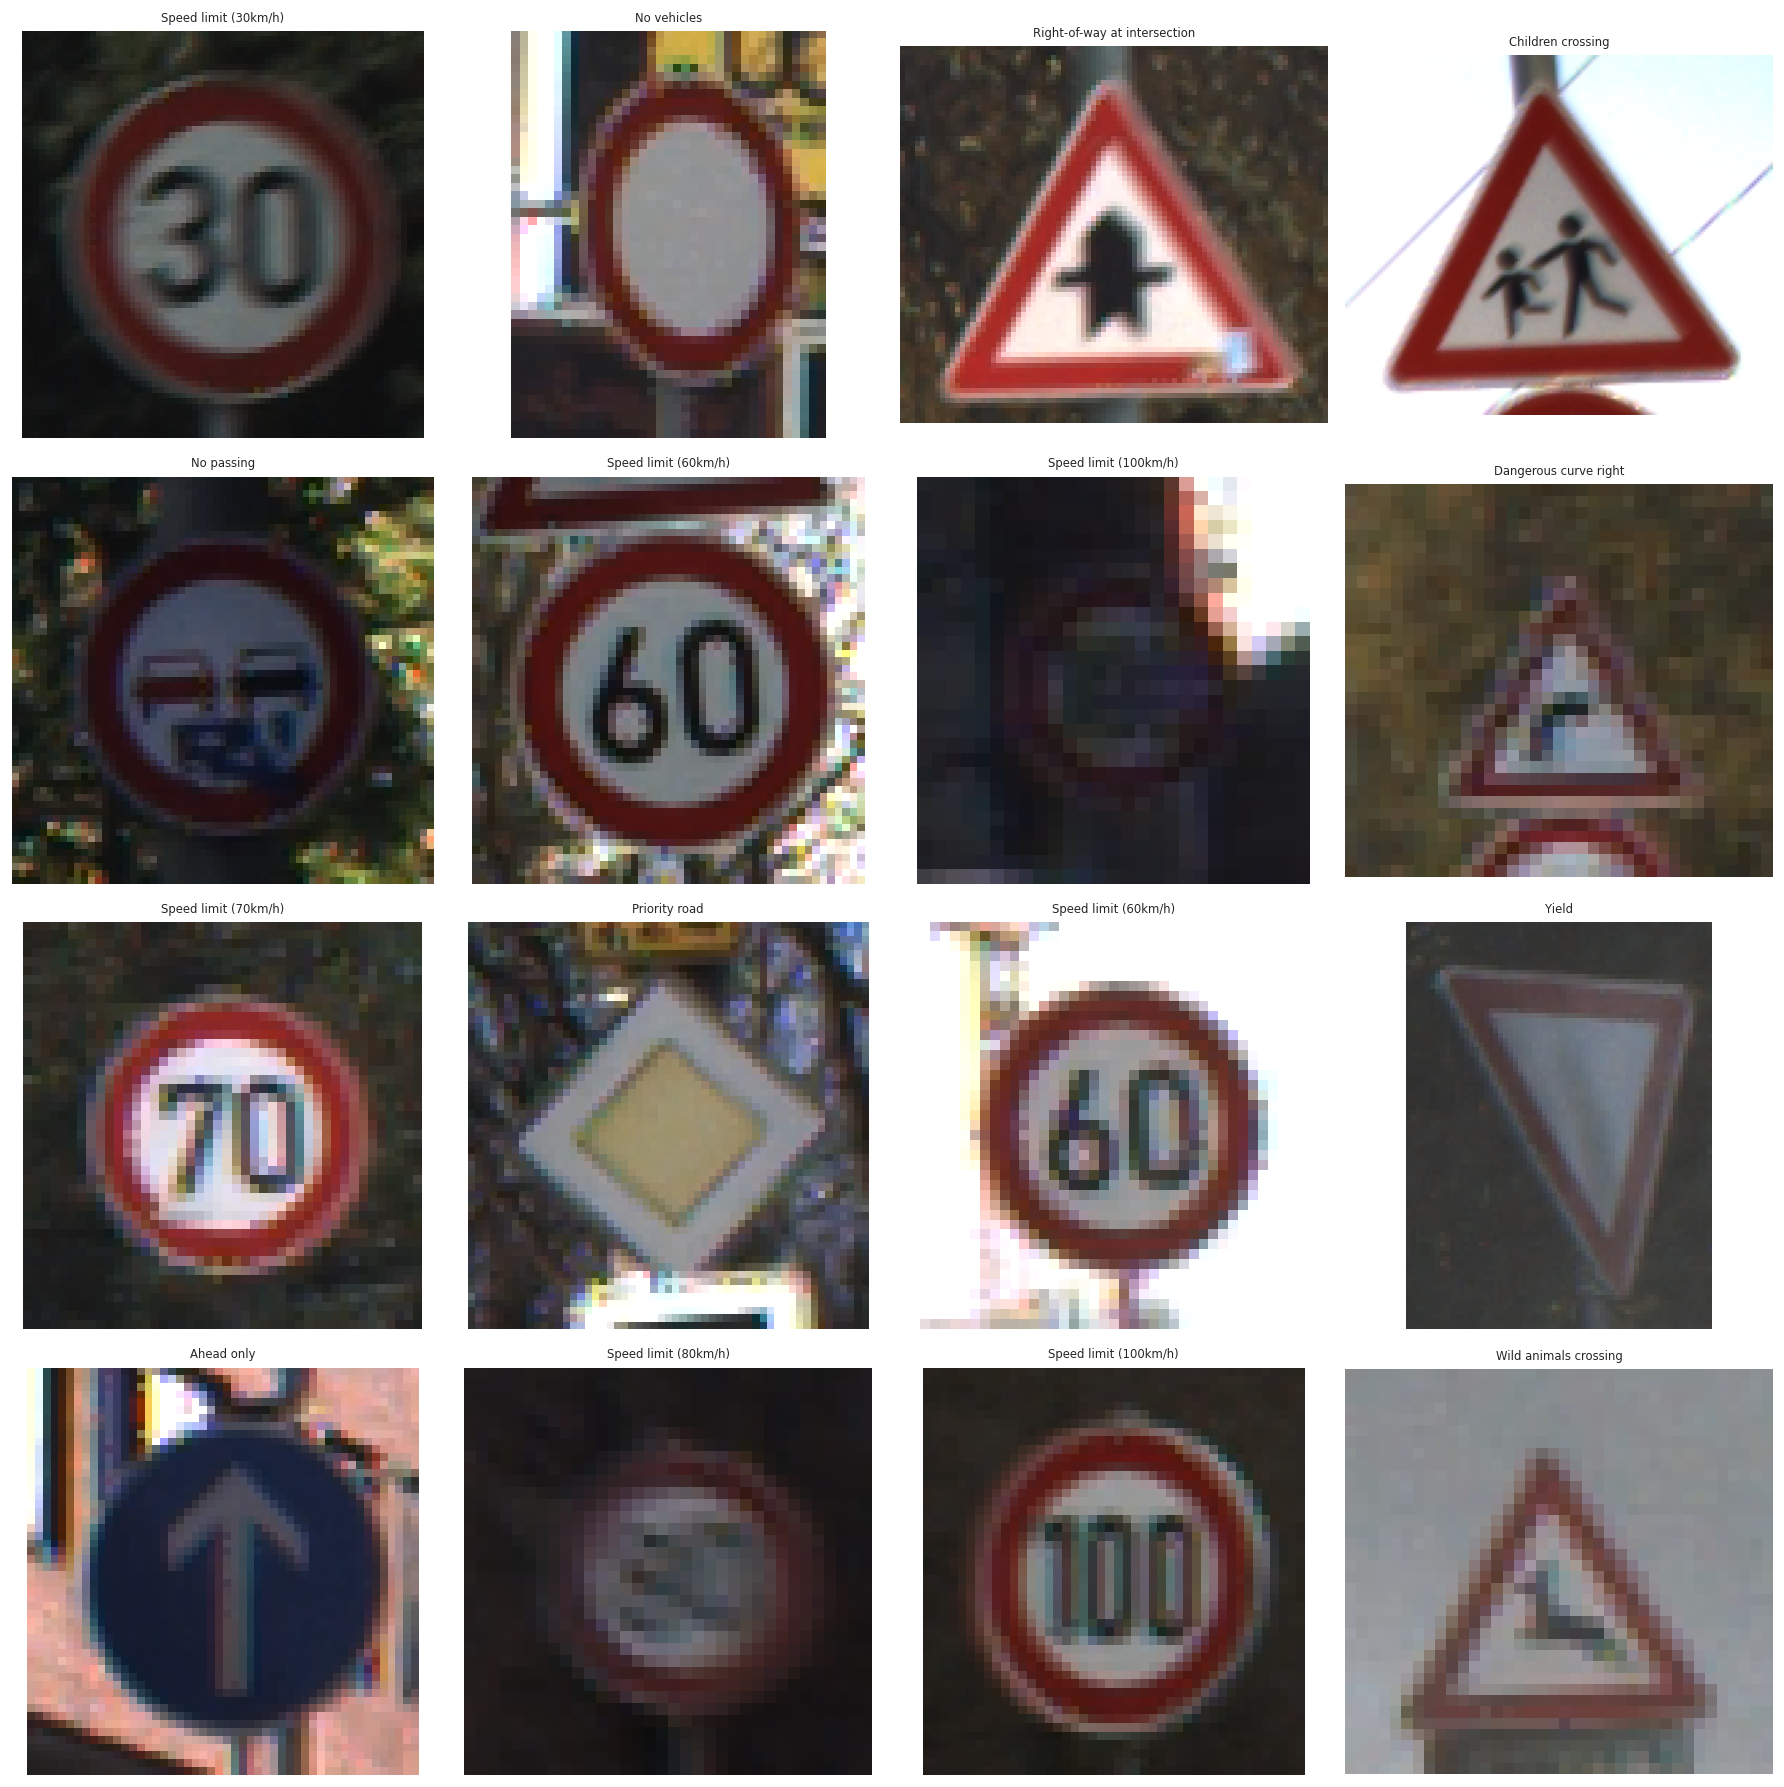

In [49]:
import random
image_paths = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

sample_paths = random.sample(image_paths, 16)
plt.figure(figsize=(15, 15), dpi = 120)

for i, img_path in enumerate(sample_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_str = os.path.basename(os.path.dirname(img_path))
    label_int = int(label_str)
    class_name = classes.get(label_int, "Unknown")
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.title(class_name, fontsize=7)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Check Data Balance



In [35]:
df_balance = pd.DataFrame()
df_balance['labels'] = list(range(43))
df_balance['train'] = train_dict.values()
df_balance['test'] = test_dict.values()
df_balance['total'] = df_balance['train'] + df_balance['test']
df_balance['train_ratio'] = df_balance['train']/df_balance['total']
df_balance['test_ratio'] = df_balance['test']/df_balance['total']

In [89]:
df_balance.head(10)


,labels,train,test,total,train_ratio,test_ratio
0,0,2250,750,3000,0.750000,0.250000
1,1,2220,720,2940,0.755102,0.244898
2,2,2160,720,2880,0.750000,0.250000
3,3,2100,690,2790,0.752688,0.247312
4,4,2070,690,2760,0.750000,0.250000
5,5,2010,660,2670,0.752809,0.247191
6,6,1980,660,2640,0.750000,0.250000
7,7,1860,630,2490,0.746988,0.253012
8,8,1500,480,1980,0.757576,0.242424
9,9,1470,480,1950,0.753846,0.246154


<Axes: title={'center': 'Train Test Ratio for each class'}, xlabel='labels'>

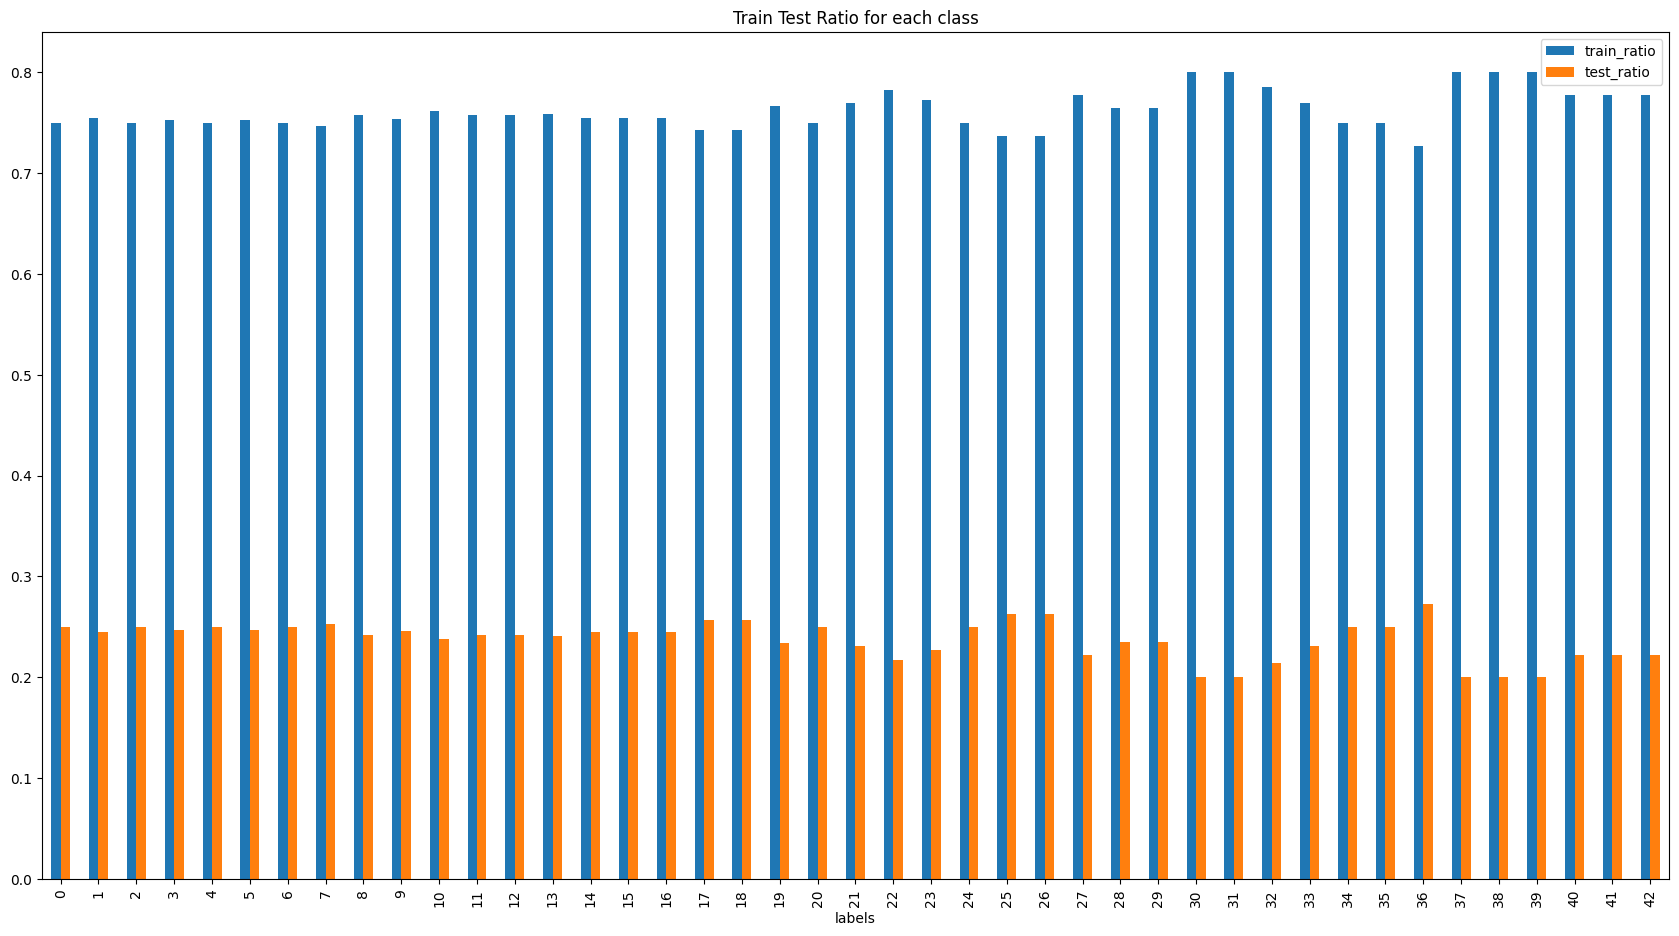

In [37]:
df_balance.plot(x = 'labels', y = ['train_ratio', 'test_ratio'], kind = 'bar', figsize = (21, 11), title = "Train Test Ratio for each class")


Tỷ lệ giữa tập huấn luyện và kiểm tra tương đối ổn định, dao động quanh khoảng 75% – 80% cho tập huấn luyện và 20% – 25% cho tập kiểm tra.

## Check Duplicate Entries


In [38]:
df_train.Path.duplicated().unique()


array([False])

In [39]:
df_test.Path.duplicated().unique()


array([False])

No duplicate entries found in train and test csv files



---

